In [21]:
import altair as alt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

sfo_df = pd.read_csv("Air_Traffic_Passenger_Statistics.csv")
sfo_df['Activity Period'] = pd.to_datetime(sfo_df['Activity Period'], format='%Y%m')

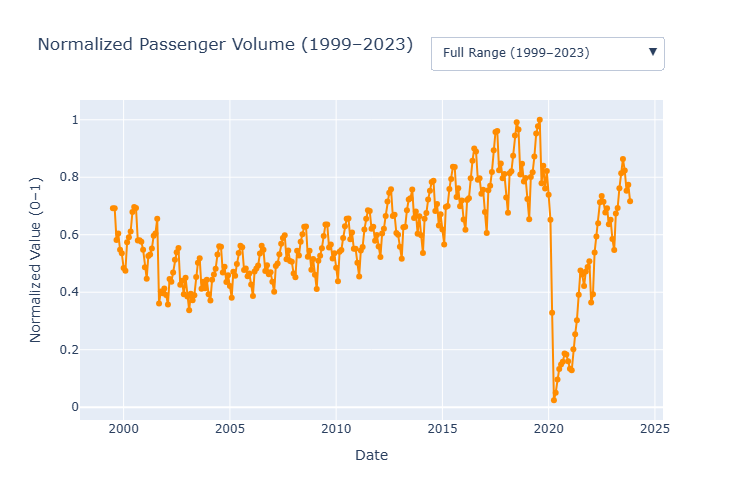

In [20]:

covid_df = pd.read_csv("rows.csv")
test_df = pd.read_csv("rows_4.csv")
sfo_df = pd.read_csv("Air_Traffic_Passenger_Statistics.csv")  # Rename if needed

covid_df['reportdate'] = pd.to_datetime(covid_df['reportdate'])
test_df['specimen_collection_date'] = pd.to_datetime(test_df['specimen_collection_date'])
sfo_df['Date'] = pd.to_datetime(sfo_df['Activity Period'], format='%Y%m')

# Aggregate full-range passenger volume (monthly)
full_monthly_df = sfo_df.groupby('Date')['Passenger Count'].sum().reset_index()
full_monthly_df = full_monthly_df[(full_monthly_df['Date'] >= '1999-01-01') & (full_monthly_df['Date'] < '2024-01-01')]
full_monthly_df['Normalized Passenger Count'] = full_monthly_df['Passenger Count'] / full_monthly_df['Passenger Count'].max()

# COVID-era data (2019–2023)
covid_sum = covid_df.groupby('reportdate')['patientcount'].sum().reset_index().rename(columns={'reportdate': 'Date', 'patientcount': 'Hospitalizations'})
test_sum = test_df.groupby('specimen_collection_date')['pos'].sum().reset_index().rename(columns={'specimen_collection_date': 'Date', 'pos': 'Positive Tests'})
monthly_df = sfo_df.groupby('Date')['Passenger Count'].sum().reset_index()

merged = pd.merge(covid_sum, test_sum, on='Date', how='outer')
merged = pd.merge(merged, monthly_df, on='Date', how='outer')
merged = merged.sort_values('Date')
merged = merged[(merged['Date'] >= '2019-01-01') & (merged['Date'] < '2024-01-01')]

# Normalize values
merged['Hospitalizations (normalized)'] = merged['Hospitalizations'] / merged['Hospitalizations'].max()
merged['Positive Tests (normalized)'] = merged['Positive Tests'] / merged['Positive Tests'].max()
merged['Passenger Count (normalized)'] = merged['Passenger Count'] / merged['Passenger Count'].max()

# Create figure
fig = go.Figure()

# Full-range passenger count
fig.add_trace(go.Scatter(
    x=full_monthly_df['Date'],
    y=full_monthly_df['Normalized Passenger Count'],
    name="Passenger Count (Full Range)",
    mode='lines+markers',
    line=dict(color='darkorange', width=2)
))

fig.add_trace(go.Scatter(
    x=merged[merged['Passenger Count (normalized)'].notna()]['Date'],
    y=merged[merged['Passenger Count (normalized)'].notna()]['Passenger Count (normalized)'],
    name="Passenger Count (COVID Only)",
    visible=False,
    mode='lines+markers',
    line=dict(color='darkorange', width=2),
    line_shape='linear',
    connectgaps=True  # <- this makes the line continuous across months
))


# COVID hospitalizations
fig.add_trace(go.Scatter(
    x=merged['Date'],
    y=merged['Hospitalizations (normalized)'],
    name="Hospitalizations",
    visible=False,
    mode='lines',
    line=dict(color='steelblue', width=1)
))

# COVID positive tests
fig.add_trace(go.Scatter(
    x=merged['Date'],
    y=merged['Positive Tests (normalized)'],
    name="Positive Tests",
    visible=False,
    mode='lines',
    line=dict(color='indianred', width=1)
))

# Add dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Full Range (1999–2023)",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Normalized Passenger Volume (1999–2023)"}]),
                dict(label="COVID Years Only (2019–2023)",
                     method="update",
                     args=[{"visible": [False, True, True, True]},
                           {"title": "COVID-19 Impact vs SFO Passenger Volume (2019–2023)"}]),
            ]),
            direction="down",
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.2,
            yanchor="top"
        ),
    ]
)

# Final layout
fig.update_layout(
    title="Normalized Passenger Volume (1999–2023)",
    xaxis_title="Date",
    yaxis_title="Normalized Value (0–1)",
    height=500,
    width=1000,
    legend_title="Category"
)

fig.show()


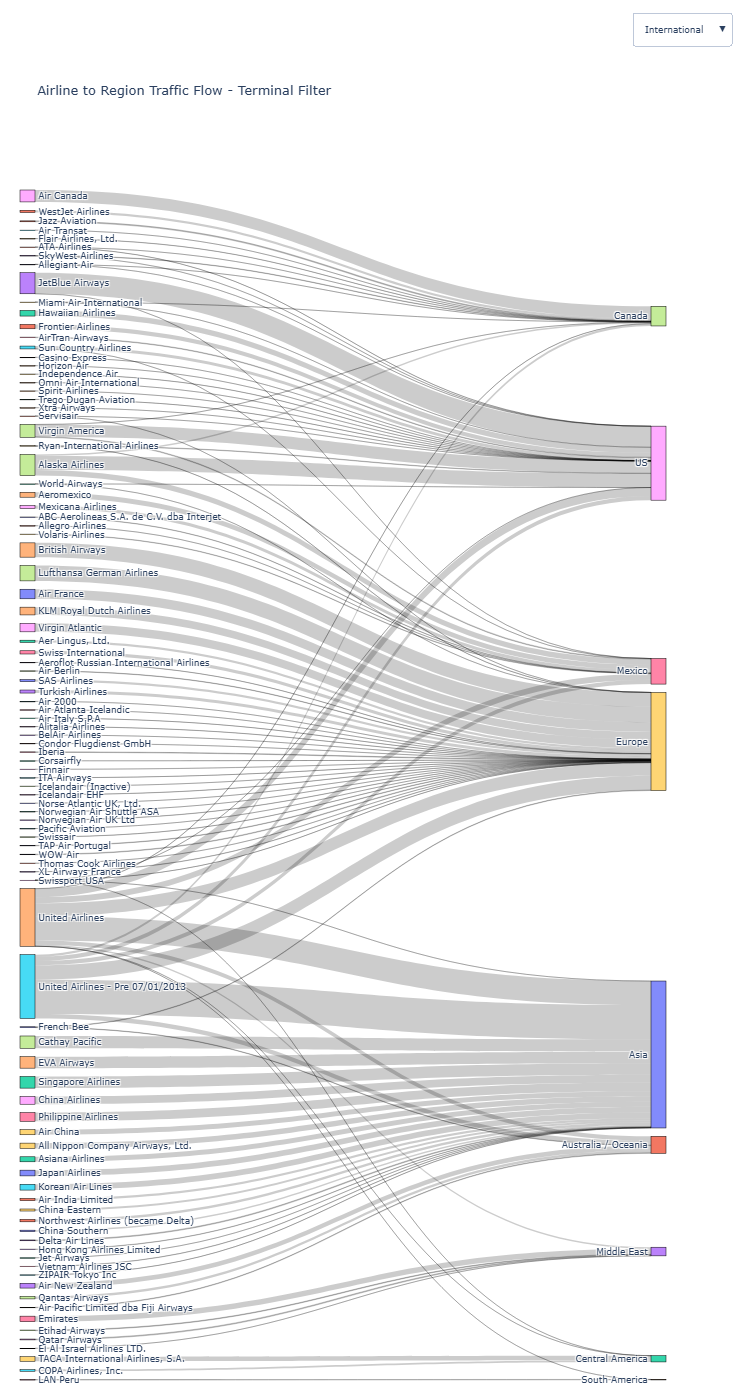

In [17]:
sfo_df = sfo_df.dropna(subset=["Operating Airline", "GEO Region", "Terminal"])
top_terminals = sfo_df["Terminal"].value_counts().nlargest(5).index.tolist()

data_traces = []
buttons = []

for i, terminal in enumerate(top_terminals):
    df_terminal = sfo_df[sfo_df["Terminal"] == terminal]
    sankey_df = df_terminal.groupby(["Operating Airline", "GEO Region"])["Passenger Count"].sum().reset_index()

    source_labels = list(sankey_df["Operating Airline"].unique())
    target_labels = list(sankey_df["GEO Region"].unique())
    labels = source_labels + target_labels

    label_map = {label: idx for idx, label in enumerate(labels)}
    sources = [label_map[airline] for airline in sankey_df["Operating Airline"]]
    targets = [label_map[region] for region in sankey_df["GEO Region"]]
    values = list(sankey_df["Passenger Count"])

    trace = go.Sankey(
        node=dict(
            pad=50,
            thickness=15,
            line=dict(color="black", width=0.5),
            label=labels,
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
        ),
        visible=(i == 0)
    )

    data_traces.append(trace)

    button = dict(
        label=f"{terminal}",
        method="update",
        args=[{"visible": [j == i for j in range(len(top_terminals))]},
              {"title": f"Airline to Region Traffic Flow - {terminal}"}]
    )
    buttons.append(button)

fig = go.Figure(data=data_traces)
fig.update_layout(
    title="Airline to Region Traffic Flow - Terminal Filter",
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.1,
        y=1.15
    )],
    margin=dict(t=80, l=20, r=20, b=20),
    font_size=9,
    height = 1400,
)

fig.show()

C:\Users\samse\AppData\Local\Temp\ipykernel_22408\349774297.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



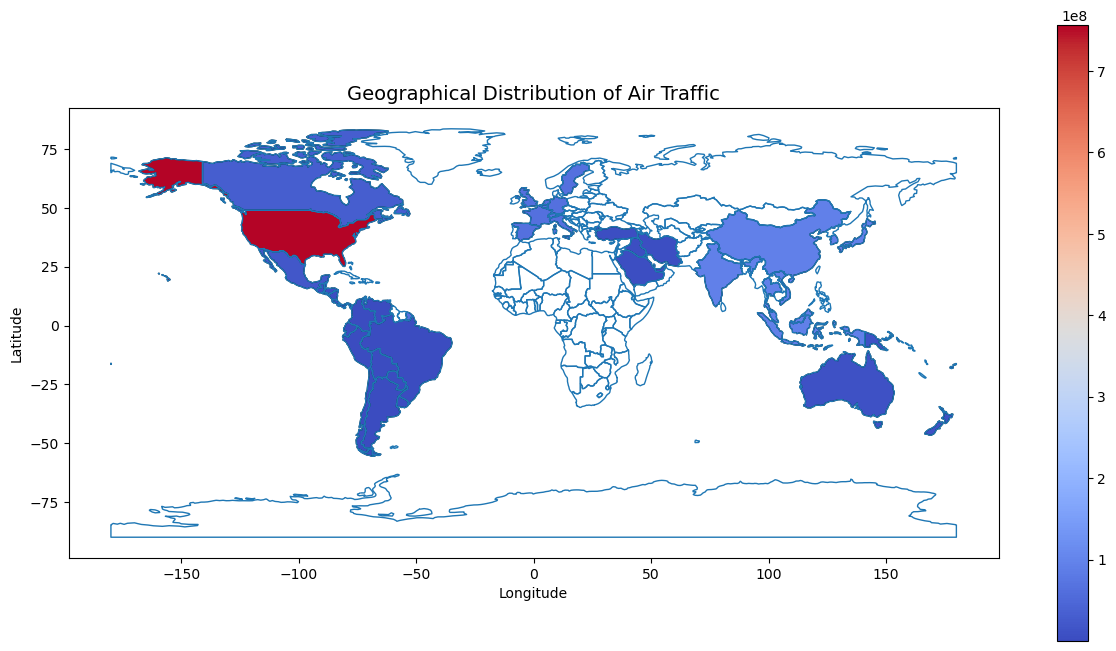

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geo_region_map = {
    "US": ["United States of America"],
    "Canada": ["Canada"],
    "Mexico": ["Mexico"],
    "Central America": ["Guatemala", "El Salvador", "Honduras", "Nicaragua", "Costa Rica", "Panama", "Belize"],
    "South America": ["Argentina", "Brazil", "Chile", "Colombia", "Peru", "Ecuador", "Bolivia", "Venezuela", "Uruguay", "Paraguay"],
    "Europe": ["United Kingdom", "Germany", "France", "Italy", "Spain", "Netherlands", "Sweden", "Switzerland", "Belgium"],
    "Asia": ["China", "India", "Japan", "South Korea", "Indonesia", "Thailand", "Malaysia", "Vietnam"],
    "Middle East": ["United Arab Emirates", "Saudi Arabia", "Qatar", "Kuwait", "Turkey", "Iran", "Iraq"],
    "Australia / Oceania": ["Australia", "New Zealand", "Fiji", "Papua New Guinea"]
}

df_expanded = sfo_df.copy()
df_expanded["GEO Region"] = df_expanded["GEO Region"].map(lambda x: geo_region_map.get(x, [x]))  
df_expanded = df_expanded.explode("GEO Region")  
geo_traffic = df_expanded.groupby("GEO Region")["Passenger Count"].sum().reset_index()
world = world.merge(geo_traffic, how="left", left_on="name", right_on="GEO Region")
fig, ax = plt.subplots(figsize=(15, 8))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column="Passenger Count", cmap="coolwarm", linewidth=0.8, edgecolor='black', legend=True, ax=ax)
ax.set_title("Geographical Distribution of Air Traffic", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
